# Numerics 1: Homework 02

## Cooper Simpson

## Setup
Here we have set up our notebook by importing any necessary Python modules, and most importantly by defining functions we will use throughout.

In [22]:
#Theme
from jupyterthemes import jtplot
!jt -t grade3
jtplot.style()

In [23]:
%%capture
#Reset the theme
!jt -r;

In [3]:
#Importing modules
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set()

In [4]:
#Here we have defined two functions for polynomial approximation
#that we will use throughout.

#This function will use Nevilles method to build polynomials to
#interpolate a given point.
def build_lagrange(x, y, val):
    pts = len(x)
    
    Q = np.zeros((pts,pts))
    Q[0,:] = y.reshape((1, pts))
    
    #Start filling in the table
    #Across and down, final is bottom right
    for i in range(1, pts):
        for j in range(i, pts):
            Q[i,j] = ((val-x[j])/(x[j-i]-x[j]))*Q[i-1,j-1] +\
                    ((val-x[j-i])/(x[j]-x[j-i]))*Q[i-1,j]
                
    return pd.DataFrame(Q)
    
    
#This function will build a cubic spline approximation
#of the given function points using whatever boundary
#condition is specified.
def build_spline(x, f, endpoints='natural'):
    num_polys = len(x)-1
    terms = 3+1
    A = np.zeros((num_polys*terms, num_polys*terms))
    b = np.zeros((num_polys*terms, 1))

    eq = 0

    #First we match all function values
    for i in range(num_polys):
        for j in range(i*4,(i+1)*4):
            A[eq][j] = x[i]**(j%4)
        b[eq] = f[i]

        for j in range(i*4,(i+1)*4):
            A[eq+1][j] = x[i+1]**(j%4)
        b[eq+1] = f[i+1]

        eq += 2

    #Then we match all junction slopes
    for i in range(1, num_polys):
        for j in range((i-1)*4+1, (i)*4):
            A[eq][j] = (j%4)*x[i]**(j%4-1)
            A[eq][j+4] = -(j%4)*x[i]**(j%4-1)
        b[eq] = 0

        eq += 1
        
    #Then we match all junction curvature
    for i in range(1, num_polys):
        for j in range((i-1)*4+2, (i)*4):
            A[eq][j] = (j%4)*((j-1)%4)*x[i]**(j%4-2)
            A[eq][j+4] = -(j%4)*((j-1)%4)*x[i]**(j%4-2)
        b[eq] = 0

        eq += 1

    #Then we match the endpoints
    #Second derivative
    if endpoints == 'natural':
        for j in range(2,4):
            A[eq][j] = (j%4)*((j-1)%4)*x[0]**(j%4-2)
        b[eq]=0

        for j in range(num_polys*terms-2, num_polys*terms):
            A[eq+1][j] = (j%4)*((j-1)%4)*x[-1]**(j%4-2)
        b[eq+1]=0

    else:
        for j in range(1,4):
            A[eq][j] = (j%4)*x[0]**(j%4-1) 

        for j in range(num_polys*terms-3, num_polys*terms):
            A[eq+1][j] = (j%4)*x[-1]**(j%4-1)

        #Analytic derivative
        if callable(endpoints):
            b[eq] = endpoints(x[0])
            b[eq+1] = endpoints(x[-1])

        #Fwd/Bkwd Difference
        elif endpoints == 'approx':
            b[eq] = (f[1]-f[0])/(x[1]-x[0])
            b[eq+1] = (f[-1]-f[-2])/(x[-1]-x[-2])

        else:
            raise Exception('Invalid Endpoint Condition')

    #Solve the linear system
    try:
        coeff = np.linalg.solve(A, b)
    except Exception as e:
        print('ERROR:')
        print(e)
        return (A,b)

    #Reshape and return
    return (coeff.T).reshape((num_polys,terms))

In [5]:
#Here we define some useful helper 
#functions for problems 3, 4, and 5.
def x_quad(x):
    return x**4

def dx_quad(x):
    return 4*x**3

def eval_spline(poly, x):
    y = np.zeros(len(x))
    
    for i,cf in enumerate(poly):
        y += cf*x**i
        
    return y

def plot_spline(polys, x, step=0.1):
    domain = np.arange(x[0],x[-1]+step,step)
    domains = []
    for i in range(len(x)-1):
        domains.append(np.arange(x[i], x[i+1]+step, step))

    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax.plot(domain, x_quad(domain))

    shape = polys.shape
    for i,d in enumerate(domains):
        ax.plot(d, eval_spline(polys[i][:].reshape(shape[1]), d))

    return fig, ax

## Problem 1

We wish to show that repeated application of $P(x) = (x-a)Q(x)+R$, a method of defining polynomials, will eventually produce the Taylor series expansion of $P(x)$.

It is sufficient to show that $R_k=\frac{P^{(k)}(a)}{k!}$. We first claim that for a polynomial $P(x)$ repeated applications of $P(x)=(x-a)Q(x)+R$ will give us the following:

$$ P(x)=(x-a)^{n}Q_{n-1}(x)+\sum_{i=0}^{n-1}(x-a)^iR_i,\;n\geq1 $$

Where $Q_i(x)$ is some polynomial and $R_i$ is some real valued constant. The $Q_0$ and $R_0$ are obtained by applying our formula to $P(x)$, and then subsequent $Q_i$ and $R_i$ are obtained by applying the formula to $Q_{i-1}$. We note that we are assuming we can write any polynomial $P(x)$ as $P(x)=(x-a)Q(x)+R$ -- we can -- by dividing our original polynomial by $(x-a)$, but we will not prove that here. We will give a short proof of the above claim:

---

### Proof: By Induction

**Base Case:**
\begin{equation*}
    n=1\implies P(x)=(x-a)Q_0(x)+R_0
\end{equation*}
This is true by assumption

We will assume that $ P(x)=(x-a)^{n}Q_{n-1}(x)+\sum_{i=0}^{n-1}(x-a)^iR_i $ holds for some $1\leq k$, and we will show that this implies it holds for $k+1$.
\begin{equation*}
    P(x)=(x-a)^{k}Q_{k-1}(x)+\sum_{i=0}^{k-1}(x-a)^iR_i
\end{equation*}
We then write $Q_{k-1} = (x-a)Q_k(x)+R_k$
\begin{align*}
    &\implies P(x) = (x-a)^{k}((x-a)Q_k(x)+R_k)+\sum_{i=0}^{k-1}(x-a)^iR_i\\
    &\implies P(x) = (x-a)^{k+1}Q_k(x)+\sum_{i=0}^{k}(x-a)^iR_i
\end{align*}

Thus we have proved the claim

---

Having proved this we simply need to look at $P^{(k)}(x)$, so for some $n+1>k$ we have $P(x) = (x-a)^{n+1}Q_{n}(x)+\sum_{i=0}^{n}(x-a)^iR_i$ and we will take $k$ derivatives. Clearly on the left hand side we will have $P^{(k)}(x)$, but the terms on the right hand side are a bit more complicated. To determine the $Q_{n}$ terms derivative we would need to repeatedly apply the product rule, but we will just reason our way through it instead. We can see that the lowest degree $(x-a)$ term after differentation will be $(x-a)^{n+1-k}$, where $n+1-k>0$ by assumption. Thus evaluating the derivative at $x=a$ will result in all of the $Q_{n}$ terms being zero as each has an $(x-a)$ multiplier of degree greater than 0. That leaves only the sum of $R_i$ to be evaluated, and because $R_i$ is only a constant it is much easier to evaluate.

$$ \frac{d^k}{d^kx} \sum_{i=0}^{n}(x-a)^iR_i = \sum_{i=k}^{n}\frac{i!}{(i-k)!}(x-a)^{i-k}R_i = k!R_k + \sum_{i=k+1}^{n}\frac{i!}{(i-k)!}(x-a)^{i-k}R_i$$

Thus evaluating at $x=a$ we can see that $P^{(k)}(a) = k!R_k$. We have shown that repeated applications of the rule will result in a Taylor series expansion, and we note that this Taylor series is centered around $x=a$ as that is the location the derivatives are evaluated at.

## Problem 2
Using Lagrange interpolating polynomials of degrees one, two, and three, we wish to approximate $f(8.4)$.

We use Neville's method to build up polynomial interpolations of $f(8.4)$ using the provided function values at the provided locations. Nevilles method builds polynomials from the function values of higher and higher order, including more and more points. In the end we will have a polynomial of degree 3 that uses all three points to approximate the function value.

In [9]:
#Test Values from class
# val = 1.5
# x = np.array([1, 1.3, 1.6, 1.9, 2.2])
# y = np.array([0.7651977, 0.6200360, 0.4554022, 0.2818186, 0.1103623])

#Our known function values
val = 8.4
x = np.array([8.1, 8.3, 8.6, 8.7])
y = np.array([16.94410, 17.56492, 18.50515, 18.82091])

Q = build_lagrange(x, y, val)
display(Q)

,0,1,2,3
0,16.9441,17.56492,18.50515,18.820910
1,0.0000,17.87533,17.87833,17.873630
2,0.0000,0.00000,17.87713,17.877155
3,0.0000,0.00000,0.00000,17.877142


In the table above we see the values for $Q_{i,j}$ that result from the use of Nevilles method. In this case $i$ (the row) is the degree of the polynomial and $j$ (the column) is the last point included.

We see that in the bottom right (index (3,3)) we have a polynomial of degree three that includes all four points and approximates $f(8.4)\approx 17.877142$. We can then look in the second and third rows for first, and second degree approximations. Given this a second degree approximation is $f(8.4)\approx 17.877155$ and a third degree is $f(8.4)\approx 17.877360$.

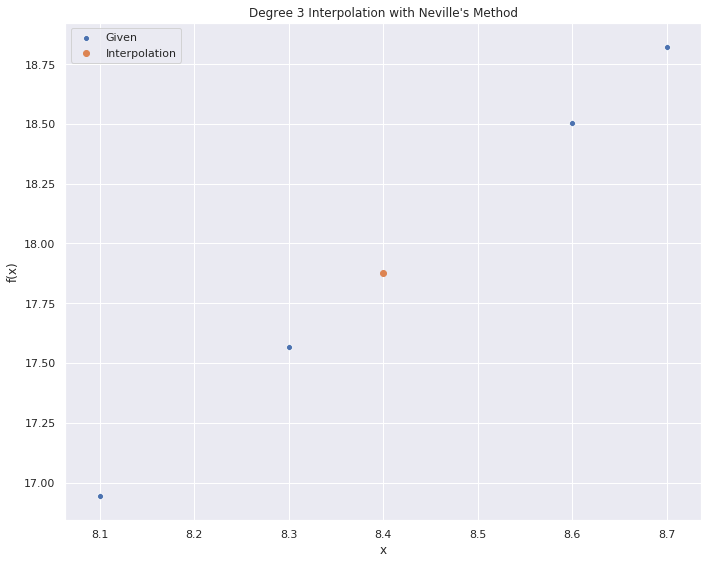

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax = sns.scatterplot(x,y) 
ax.scatter(val, Q[3][3])

ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title("Degree 3 Interpolation with Neville's Method")
ax.legend(['Given', 'Interpolation'])
plt.tight_layout()

In the plot above we have plotted our given points, and our interpolated value using the third degree approximation. We can see that it gives what appears to be a very accurate approximation based on the given points around it.

## Problem 3
Use cubic splines to approximate the function $f(x)=x^4$ on $-3\leq x\leq3$.

Use the function at the points $x=-3,\;-1,\;1,\;3$, and match the slope at $x=-3$ and $x=3$. We use the standard approach to building splines by developing a system of equations based on various conditions and then solving this linear system for the coefficients.

In [12]:
x = np.array([-3, -1, 1, 3])
y = x_quad(x)

polys = build_spline(x, y, endpoints=dx_quad)
print(polys)

[[ -9. -24. -22.  -8.]
 [ -1.   0.   2.   0.]
 [ -9.  24. -22.   8.]]


In the 2-dimensional array printed above we can see the coefficients for three polynomials. The columns are ascending powers with each row representing a polynomial valid on a different domain. If we take these values we get the following:

$$
\begin{align*}
    &-8x^3 -22x^2 -24x -9,\;&x\in[-3,-1]\\
    &2x^2 -1,\;&x\in[-1,1]\\
    &8x^3 -22x^2 +24x -9,\;&x\in[1,2]
\end{align*}
$$

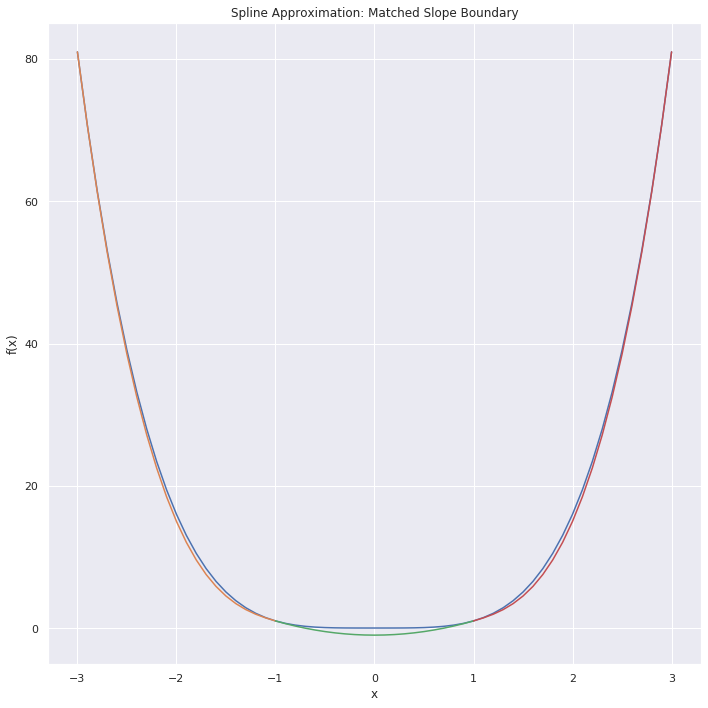

In [13]:
fig, ax = plot_spline(polys, x)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title('Spline Approximation: Matched Slope Boundary')
fig.tight_layout()

In the plot above we see the function $f(x)=x^4$ along with the cubic spline approximations. It is clear to see that the splines do a good job of approximation, with the greatest error coming from the -1 to 1 domain. Matching the derivatives at the endpoints helps ensure a good approximation.

## Problem 4
Use cubic splines to approximate the function $f(x)=x^4$ on $-1\leq x\leq1$.

Use the function values at $x=-1,\;0,\;1$, and match the slope to the forward and backward approximations of $f'(x)$ (shown below) at $x=-1,\;1$.

$$
\begin{align}
&f'(x_0)\approx\frac{f_1-f_0}{h} &f'(x_2)\approx\frac{f_2-f_1}{h}
\end{align}
$$

In [14]:
x = np.array([-1, 0, 1])
y = x_quad(x)

polys = build_spline(x, y, endpoints='approx')
print(polys)

[[ 0.00000000e+00 -2.22044605e-16  2.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00 -3.33066907e-16  2.00000000e+00 -1.00000000e+00]]


Like in problem 3 we see the coefficients for our cubic splines in the array above. This gives us the following polynomials:

$$
\begin{align*}
    &x^3 + 2x^2 -2.22*10^{-16}x,\;&x\in[-1,0]\\
    &-x^3 + 2x^2 -3.33*10^{-16}x,\;&x\in[0,1]
\end{align*}
$$

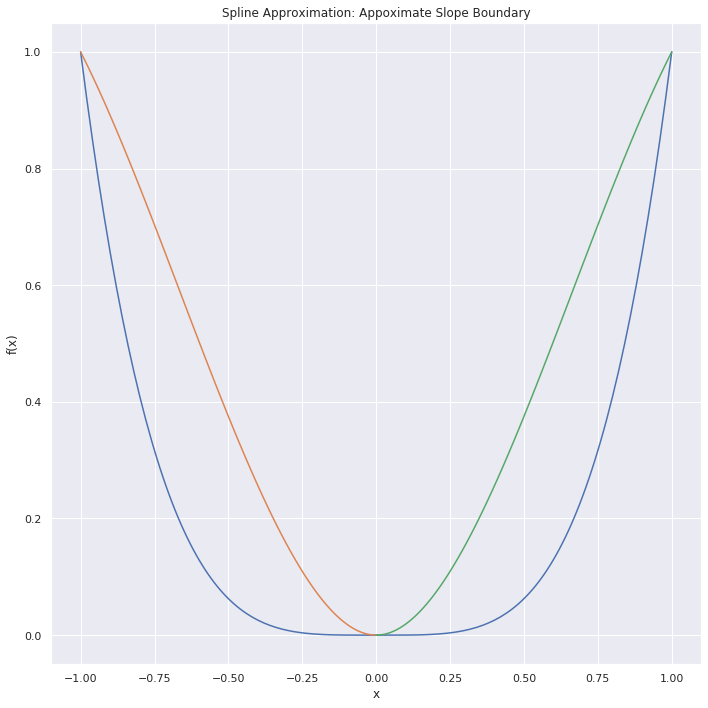

In [15]:
fig, ax = plot_spline(polys, x, step=0.01)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title('Spline Approximation: Appoximate Slope Boundary')
fig.tight_layout()

In the plot above we see cubic spline approximation of the function $f(x)=x^4$. We see that the splines have done a much poorer job of approximating our function than in problem 3. This is because the forward and backward derivative approximations are not very accurate at all, and we are using fewer points in general.

## Problem 5
Use cubic splines to approximate the function $f(x)=x^4$ on $-1\leq x\leq1$.

Use the function values at $x=-1,\;0,\;1$ along with free boundary conditions at $x=-1,\;1$.

In [16]:
x = np.array([-1, 0, 1])
y = x_quad(x)

polys = build_spline(x, y, endpoints='natural')
print(polys)

[[ 0.00000000e+00  0.00000000e+00  1.50000000e+00  5.00000000e-01]
 [ 0.00000000e+00  1.11022302e-16  1.50000000e+00 -5.00000000e-01]]


Similar to problems 3 and 4 we can see our cubic spline polynomial coefficients in the array above. This gives us the following:

$$
\begin{align*}
    &0.5x^3 + 1.5x^2,\;&x\in[-1,0]\\
    &-0.5x^3 + 1.5x^2 +1.11*10^{-16}x,\;&x\in[0,1]\\
\end{align*}
$$

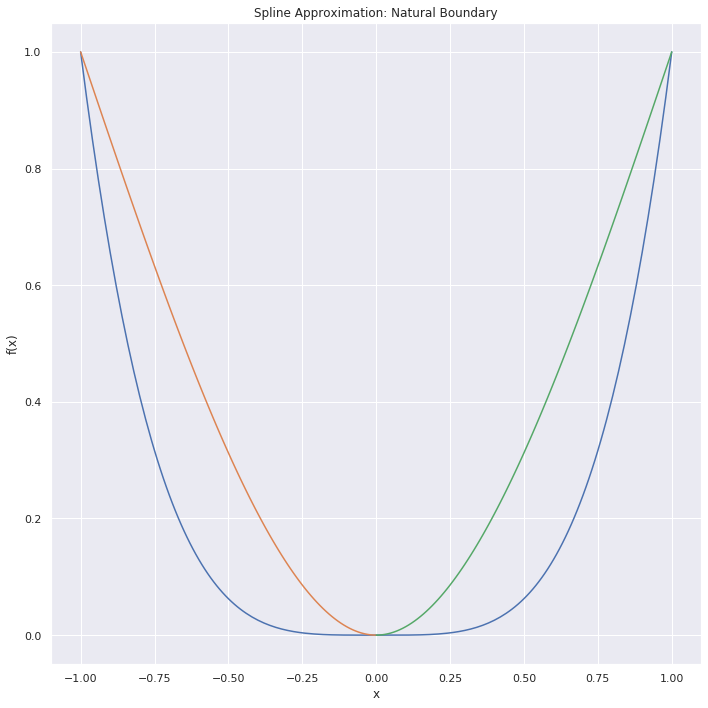

In [17]:
fig, ax = plot_spline(polys,x, step=0.01)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title('Spline Approximation: Natural Boundary')
fig.tight_layout()

In the plot above we see cubic spline approximation of the function $f(x)=x^4$. Again we have a much poorer approximation than seen in problem 3. This is again because we are using fewer points and not matching the exact derivative values at the endpoints. We are instead using natural boundary conditions, which seem to do a better job than the approximations, but still fall short.